# Initialization

## Import

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from utils.save_load_utils import save_model, load_model
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
from utils.evaluation_utils import calculate_miou, check_acc
                                                                     
import albumentations as A

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


## Hyperparameters

In [33]:
hyperparameters = {
    'test_dir' : './images/test',
    'train_dir' : './images/train',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'vgg19': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
    }, 
    'pre_trained_path': 'checkpoints/pretrained/pretrained_best.pth.tar',
    'checkpoints_dir': './checkpoints/daft/',
    'output_dir':{
        'results':'./generated_examples/',
        'model':'./generated_examples/daft/',
    },
}

## Seed Everything

In [34]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

# Data Preprocessing

## Data Augmentation

In [35]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

## Dataset

In [36]:
from dataset.dataset import seg_datasets

train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(104, 27)

In [37]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [38]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3., 4.])

In [39]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


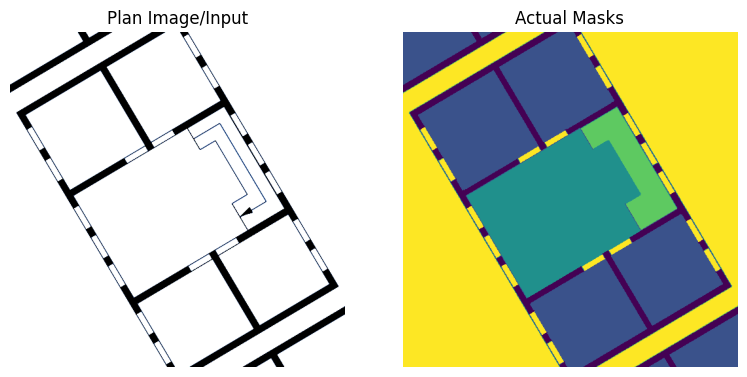

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [41]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
    4: (255, 255, 0),     # Stairs
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

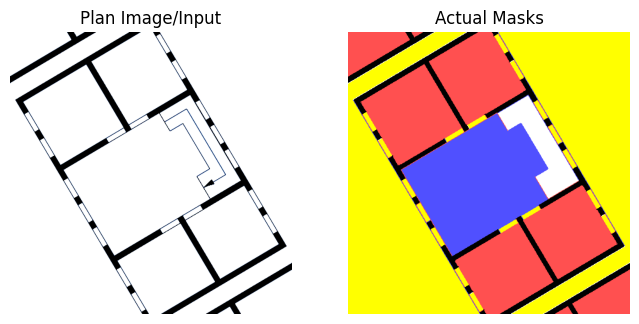

In [42]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [43]:
from utils.dataloader_utils import get_loader

train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(13, 4)

In [44]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [45]:
from models.vgg19 import VGGUNET19

model = VGGUNET19(
    features = hyperparameters['vgg19']['features'], 
    in_channels=hyperparameters['vgg19']['in_channels'], 
    out_channels=hyperparameters['vgg19']['out_channels']
)

In [46]:
"""
checkpoint = torch.load(hyperparameters['pre_trained_path'])
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

model.to(device)
"""

"\ncheckpoint = torch.load(hyperparameters['pre_trained_path'])\nmodel.load_state_dict(checkpoint['model_state_dict'], strict=True)\n\nmodel.to(device)\n"

In [47]:
"""
# Tüm katmanları serbest bırakmak yerine yalnızca son birkaç katmanı güncellemek için "requires_grad" ayarı yapılır.
for param in model.parameters():
    param.requires_grad = False

# Yeni veri bölgesine uyum sağlamak için encoder'ın en üst katmanları ve decoder katmanları açılır
for layer in [model.inc, model.down1, model.down2, model.up3, model.up4, model.out]:
    for param in layer.parameters():
        param.requires_grad = True
"""

'\n# Tüm katmanları serbest bırakmak yerine yalnızca son birkaç katmanı güncellemek için "requires_grad" ayarı yapılır.\nfor param in model.parameters():\n    param.requires_grad = False\n\n# Yeni veri bölgesine uyum sağlamak için encoder\'ın en üst katmanları ve decoder katmanları açılır\nfor layer in [model.inc, model.down1, model.down2, model.up3, model.up4, model.out]:\n    for param in layer.parameters():\n        param.requires_grad = True\n'

## Number of Parameters

In [48]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['vgg19']['in_channels']
__width = 512
__height = 512

dummy_input = torch.randn((__batch_size, __in_channels, __height, __width))
dummy_out = model(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')

Model input size: torch.Size([1, 3, 512, 512])
Model output size: torch.Size([1, 1, 512, 512])


In [49]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model.parameters()):,}')

Number of Parameters: 25,427,968


# Loss & Optimizer

## Loss Function

In [50]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(pred, mask, alpha=0.01):
    
    loss_by_pixel = criterion(pred, mask)
    loss = loss_by_pixel.mean()
    
    return loss

## Optimizer & Scheduler

In [51]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    betas = betas, 
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=40, factor=0.1)

# Training

## Train/Evaluation Function

In [52]:
from train_eval_func import train_fn, eval_fn

## Start Training

In [53]:
best_model = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'train_loss': [],
    'eval_loss' : [],
    'eval_miou' : [],
    'eval_acc' : [],
}

In [54]:
def train_start():
    model.to(device)
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            train_size = hyperparameters['training_size'], 
            model = model,
            dataloader = train_dataloader, 
            optimizer = optimizer, 
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            test_size = hyperparameters['test_size'], 
            model = model, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        history['eval_miou'].append(eval_miou)
        history['eval_acc'].append(eval_acc)
        
        save_model(
            model=model, 
            optimizer=optimizer, 
            root_folder=hyperparameters['checkpoints_dir'], 
            file_name='Daft_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model['best_eval_miou']:
            best_model['best_state_dict'] = model.state_dict().copy()
            best_model['best_epoch'] = epoch
            best_model['best_eval_loss'] = eval_loss
            best_model['best_eval_miou'] = eval_miou
            best_model['best_eval_acc'] = eval_acc
            
            save_model(
                model=model, 
                optimizer=optimizer, 
                root_folder=hyperparameters['checkpoints_dir'], 
                file_name='Daft_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model, 
                last_epoch=epoch, 
                verbose=True)
            
            save_model(
                model=model, 
                optimizer=optimizer, 
                root_folder='./checkpoints/unsupervised/', 
                file_name='UL_Segmentation',
                hyperparameter_dict=hyperparameters, 
                best_model=best_model, 
                last_epoch=epoch, )
            
        scheduler.step(eval_loss)

## Model Training

In [55]:
train_start()

Eval/Epoch 1/150: 100%|██████████| 27/27 [00:03<00:00,  7.21img/s]


"
        Epoch: 1, 
        Average Train Loss: 5.2590 |
        Average Test Loss: 6.4403 |
        Average Test mIoU: 1.21
        Average Test Accuracy: 6.1298370361328125
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|██████████| 27/27 [00:03<00:00,  7.58img/s]


"
        Epoch: 2, 
        Average Train Loss: 3.8528 |
        Average Test Loss: 4.0515 |
        Average Test mIoU: 7.55
        Average Test Accuracy: 33.62312316894531
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 3/150: 100%|██████████| 27/27 [00:03<00:00,  7.61img/s]


"
        Epoch: 3, 
        Average Train Loss: 2.8928 |
        Average Test Loss: 2.6888 |
        Average Test mIoU: 3.55
        Average Test Accuracy: 9.473419189453125


Eval/Epoch 4/150: 100%|██████████| 27/27 [00:04<00:00,  5.49img/s]


"
        Epoch: 4, 
        Average Train Loss: 2.4701 |
        Average Test Loss: 2.4593 |
        Average Test mIoU: 0.50
        Average Test Accuracy: 1.19781494140625


Eval/Epoch 5/150: 100%|██████████| 27/27 [00:04<00:00,  5.78img/s]


"
        Epoch: 5, 
        Average Train Loss: 2.1894 |
        Average Test Loss: 1.9099 |
        Average Test mIoU: 1.27
        Average Test Accuracy: 2.20794677734375


Eval/Epoch 6/150: 100%|██████████| 27/27 [00:03<00:00,  7.00img/s]


"
        Epoch: 6, 
        Average Train Loss: 1.9978 |
        Average Test Loss: 1.5656 |
        Average Test mIoU: 3.66
        Average Test Accuracy: 6.416066646575928


Eval/Epoch 7/150: 100%|██████████| 27/27 [00:04<00:00,  5.66img/s]


"
        Epoch: 7, 
        Average Train Loss: 1.8124 |
        Average Test Loss: 1.5483 |
        Average Test mIoU: 5.90
        Average Test Accuracy: 12.199783325195312


Eval/Epoch 8/150: 100%|██████████| 27/27 [00:03<00:00,  7.46img/s]


"
        Epoch: 8, 
        Average Train Loss: 1.6991 |
        Average Test Loss: 1.5164 |
        Average Test mIoU: 2.48
        Average Test Accuracy: 5.234654903411865


Eval/Epoch 9/150: 100%|██████████| 27/27 [00:03<00:00,  7.44img/s]


"
        Epoch: 9, 
        Average Train Loss: 1.5286 |
        Average Test Loss: 1.3878 |
        Average Test mIoU: 1.95
        Average Test Accuracy: 3.5509746074676514


Eval/Epoch 10/150: 100%|██████████| 27/27 [00:03<00:00,  7.85img/s]


"
        Epoch: 10, 
        Average Train Loss: 1.4061 |
        Average Test Loss: 1.3188 |
        Average Test mIoU: 2.21
        Average Test Accuracy: 3.8194022178649902


Eval/Epoch 11/150: 100%|██████████| 27/27 [00:03<00:00,  7.50img/s]


"
        Epoch: 11, 
        Average Train Loss: 1.2731 |
        Average Test Loss: 1.3091 |
        Average Test mIoU: 2.81
        Average Test Accuracy: 5.315272331237793


Eval/Epoch 12/150: 100%|██████████| 27/27 [00:03<00:00,  7.80img/s]


"
        Epoch: 12, 
        Average Train Loss: 1.1684 |
        Average Test Loss: 0.8461 |
        Average Test mIoU: 12.80
        Average Test Accuracy: 27.839534759521484
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 13/150: 100%|██████████| 27/27 [00:04<00:00,  5.95img/s]


"
        Epoch: 13, 
        Average Train Loss: 1.0775 |
        Average Test Loss: 1.0133 |
        Average Test mIoU: 7.05
        Average Test Accuracy: 13.94831371307373


Eval/Epoch 14/150: 100%|██████████| 27/27 [00:03<00:00,  7.29img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.9704 |
        Average Test Loss: 0.8402 |
        Average Test mIoU: 7.82
        Average Test Accuracy: 16.707611083984375


Eval/Epoch 15/150: 100%|██████████| 27/27 [00:03<00:00,  7.19img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.8661 |
        Average Test Loss: 0.7176 |
        Average Test mIoU: 10.72
        Average Test Accuracy: 21.134313583374023


Eval/Epoch 16/150: 100%|██████████| 27/27 [00:03<00:00,  7.63img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.7661 |
        Average Test Loss: 0.8036 |
        Average Test mIoU: 8.52
        Average Test Accuracy: 19.69820785522461


Eval/Epoch 17/150: 100%|██████████| 27/27 [00:03<00:00,  7.70img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.6940 |
        Average Test Loss: 0.7743 |
        Average Test mIoU: 5.96
        Average Test Accuracy: 10.829290390014648


Eval/Epoch 18/150: 100%|██████████| 27/27 [00:03<00:00,  7.83img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.6447 |
        Average Test Loss: 2.1116 |
        Average Test mIoU: 16.91
        Average Test Accuracy: 8.810806274414062
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 19/150: 100%|██████████| 27/27 [00:03<00:00,  7.71img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.6451 |
        Average Test Loss: 0.6088 |
        Average Test mIoU: 21.98
        Average Test Accuracy: 36.28959655761719
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 20/150: 100%|██████████| 27/27 [00:03<00:00,  7.69img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.5755 |
        Average Test Loss: 0.6203 |
        Average Test mIoU: 22.52
        Average Test Accuracy: 41.4675407409668
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 21/150: 100%|██████████| 27/27 [00:03<00:00,  7.51img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.5115 |
        Average Test Loss: 0.7994 |
        Average Test mIoU: 6.56
        Average Test Accuracy: 11.292013168334961


Eval/Epoch 22/150: 100%|██████████| 27/27 [00:03<00:00,  7.65img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.4306 |
        Average Test Loss: 0.2767 |
        Average Test mIoU: 48.91
        Average Test Accuracy: 59.02582931518555
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 23/150: 100%|██████████| 27/27 [00:04<00:00,  5.76img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.3850 |
        Average Test Loss: 1.7635 |
        Average Test mIoU: 35.00
        Average Test Accuracy: 50.02352523803711


Eval/Epoch 24/150: 100%|██████████| 27/27 [00:05<00:00,  5.24img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.3612 |
        Average Test Loss: 0.2684 |
        Average Test mIoU: 48.65
        Average Test Accuracy: 59.53165817260742


Eval/Epoch 25/150: 100%|██████████| 27/27 [00:05<00:00,  5.32img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.3109 |
        Average Test Loss: 0.3343 |
        Average Test mIoU: 37.17
        Average Test Accuracy: 39.685951232910156


Eval/Epoch 26/150: 100%|██████████| 27/27 [00:04<00:00,  6.60img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.3189 |
        Average Test Loss: 0.2331 |
        Average Test mIoU: 63.08
        Average Test Accuracy: 88.44833374023438
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 27/150: 100%|██████████| 27/27 [00:04<00:00,  5.61img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.2663 |
        Average Test Loss: 0.2225 |
        Average Test mIoU: 70.48
        Average Test Accuracy: 91.63169860839844
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 28/150: 100%|██████████| 27/27 [00:04<00:00,  5.74img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.2264 |
        Average Test Loss: 0.2136 |
        Average Test mIoU: 64.15
        Average Test Accuracy: 91.6161880493164


Eval/Epoch 29/150: 100%|██████████| 27/27 [00:04<00:00,  5.66img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1987 |
        Average Test Loss: 1.8276 |
        Average Test mIoU: 41.06
        Average Test Accuracy: 60.779571533203125


Eval/Epoch 30/150: 100%|██████████| 27/27 [00:04<00:00,  5.67img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1922 |
        Average Test Loss: 0.1128 |
        Average Test mIoU: 76.68
        Average Test Accuracy: 93.9385757446289
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 31/150: 100%|██████████| 27/27 [00:04<00:00,  5.60img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.2008 |
        Average Test Loss: 0.1676 |
        Average Test mIoU: 72.18
        Average Test Accuracy: 91.10272979736328


Eval/Epoch 32/150: 100%|██████████| 27/27 [00:04<00:00,  5.68img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1730 |
        Average Test Loss: 0.1364 |
        Average Test mIoU: 71.13
        Average Test Accuracy: 89.2791748046875


Eval/Epoch 33/150: 100%|██████████| 27/27 [00:04<00:00,  5.59img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1566 |
        Average Test Loss: 0.1420 |
        Average Test mIoU: 70.64
        Average Test Accuracy: 88.23865509033203


Eval/Epoch 34/150: 100%|██████████| 27/27 [00:04<00:00,  5.54img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1620 |
        Average Test Loss: 0.2163 |
        Average Test mIoU: 68.64
        Average Test Accuracy: 90.97455596923828


Eval/Epoch 35/150: 100%|██████████| 27/27 [00:04<00:00,  5.64img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1502 |
        Average Test Loss: 0.0980 |
        Average Test mIoU: 78.84
        Average Test Accuracy: 95.3125
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 36/150: 100%|██████████| 27/27 [00:04<00:00,  5.67img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1554 |
        Average Test Loss: 0.0970 |
        Average Test mIoU: 79.80
        Average Test Accuracy: 93.71770477294922
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 37/150: 100%|██████████| 27/27 [00:03<00:00,  7.57img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1567 |
        Average Test Loss: 0.1478 |
        Average Test mIoU: 69.47
        Average Test Accuracy: 84.11344146728516


Eval/Epoch 38/150: 100%|██████████| 27/27 [00:03<00:00,  7.55img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1683 |
        Average Test Loss: 0.0895 |
        Average Test mIoU: 76.91
        Average Test Accuracy: 93.60478973388672


Eval/Epoch 39/150: 100%|██████████| 27/27 [00:03<00:00,  7.45img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.1426 |
        Average Test Loss: 0.1383 |
        Average Test mIoU: 70.26
        Average Test Accuracy: 83.77532958984375


Eval/Epoch 40/150: 100%|██████████| 27/27 [00:04<00:00,  5.48img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.1202 |
        Average Test Loss: 0.0951 |
        Average Test mIoU: 77.98
        Average Test Accuracy: 94.55223083496094


Eval/Epoch 41/150: 100%|██████████| 27/27 [00:04<00:00,  5.60img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.1299 |
        Average Test Loss: 0.0868 |
        Average Test mIoU: 80.75
        Average Test Accuracy: 95.72944641113281
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 42/150: 100%|██████████| 27/27 [00:04<00:00,  5.56img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.1260 |
        Average Test Loss: 0.0710 |
        Average Test mIoU: 82.52
        Average Test Accuracy: 95.62581634521484
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 43/150: 100%|██████████| 27/27 [00:04<00:00,  5.62img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.1414 |
        Average Test Loss: 0.0761 |
        Average Test mIoU: 82.73
        Average Test Accuracy: 96.21162414550781
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 44/150: 100%|██████████| 27/27 [00:04<00:00,  5.54img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.1220 |
        Average Test Loss: 0.0726 |
        Average Test mIoU: 85.10
        Average Test Accuracy: 97.5945816040039
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 45/150: 100%|██████████| 27/27 [00:04<00:00,  5.74img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.1126 |
        Average Test Loss: 0.0589 |
        Average Test mIoU: 86.82
        Average Test Accuracy: 97.38642883300781
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 46/150: 100%|██████████| 27/27 [00:04<00:00,  5.72img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.1019 |
        Average Test Loss: 0.0636 |
        Average Test mIoU: 85.43
        Average Test Accuracy: 96.88517761230469


Eval/Epoch 47/150: 100%|██████████| 27/27 [00:04<00:00,  5.50img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.1197 |
        Average Test Loss: 0.0709 |
        Average Test mIoU: 84.26
        Average Test Accuracy: 96.94900512695312


Eval/Epoch 48/150: 100%|██████████| 27/27 [00:04<00:00,  5.48img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.0938 |
        Average Test Loss: 0.0591 |
        Average Test mIoU: 85.92
        Average Test Accuracy: 97.14228820800781


Eval/Epoch 49/150: 100%|██████████| 27/27 [00:04<00:00,  5.44img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.1015 |
        Average Test Loss: 0.1236 |
        Average Test mIoU: 77.93
        Average Test Accuracy: 94.61682891845703


Eval/Epoch 50/150: 100%|██████████| 27/27 [00:04<00:00,  5.48img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.1090 |
        Average Test Loss: 0.0605 |
        Average Test mIoU: 86.30
        Average Test Accuracy: 97.24986267089844


Eval/Epoch 51/150: 100%|██████████| 27/27 [00:03<00:00,  7.47img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.0934 |
        Average Test Loss: 0.0554 |
        Average Test mIoU: 86.18
        Average Test Accuracy: 97.59674072265625


Eval/Epoch 52/150: 100%|██████████| 27/27 [00:04<00:00,  6.63img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0942 |
        Average Test Loss: 0.0832 |
        Average Test mIoU: 79.44
        Average Test Accuracy: 95.06797790527344


Eval/Epoch 53/150: 100%|██████████| 27/27 [00:04<00:00,  5.59img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.1070 |
        Average Test Loss: 0.1011 |
        Average Test mIoU: 78.20
        Average Test Accuracy: 90.46720123291016


Eval/Epoch 54/150: 100%|██████████| 27/27 [00:04<00:00,  5.63img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0846 |
        Average Test Loss: 0.0595 |
        Average Test mIoU: 85.01
        Average Test Accuracy: 98.16754913330078


Eval/Epoch 55/150: 100%|██████████| 27/27 [00:03<00:00,  7.61img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0925 |
        Average Test Loss: 0.0661 |
        Average Test mIoU: 83.47
        Average Test Accuracy: 94.79840850830078


Eval/Epoch 56/150: 100%|██████████| 27/27 [00:03<00:00,  7.45img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0829 |
        Average Test Loss: 0.0563 |
        Average Test mIoU: 86.61
        Average Test Accuracy: 97.54613494873047


Eval/Epoch 57/150: 100%|██████████| 27/27 [00:04<00:00,  5.50img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0720 |
        Average Test Loss: 0.0650 |
        Average Test mIoU: 85.41
        Average Test Accuracy: 97.18272399902344


Eval/Epoch 58/150: 100%|██████████| 27/27 [00:04<00:00,  5.51img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.1003 |
        Average Test Loss: 0.0677 |
        Average Test mIoU: 84.11
        Average Test Accuracy: 97.03585815429688


Eval/Epoch 59/150: 100%|██████████| 27/27 [00:04<00:00,  5.57img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0904 |
        Average Test Loss: 0.0735 |
        Average Test mIoU: 83.69
        Average Test Accuracy: 95.00579833984375


Eval/Epoch 60/150: 100%|██████████| 27/27 [00:04<00:00,  5.71img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0867 |
        Average Test Loss: 0.0464 |
        Average Test mIoU: 88.87
        Average Test Accuracy: 98.46471405029297
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 61/150: 100%|██████████| 27/27 [00:04<00:00,  5.82img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0932 |
        Average Test Loss: 0.0828 |
        Average Test mIoU: 82.17
        Average Test Accuracy: 97.14889526367188


Eval/Epoch 62/150: 100%|██████████| 27/27 [00:04<00:00,  5.54img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0863 |
        Average Test Loss: 0.0706 |
        Average Test mIoU: 84.34
        Average Test Accuracy: 95.38600158691406


Eval/Epoch 63/150: 100%|██████████| 27/27 [00:04<00:00,  5.53img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0973 |
        Average Test Loss: 0.0982 |
        Average Test mIoU: 79.36
        Average Test Accuracy: 94.95862579345703


Eval/Epoch 64/150: 100%|██████████| 27/27 [00:04<00:00,  5.92img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0850 |
        Average Test Loss: 0.0527 |
        Average Test mIoU: 88.22
        Average Test Accuracy: 98.6443862915039


Eval/Epoch 65/150: 100%|██████████| 27/27 [00:04<00:00,  5.55img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0894 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 89.21
        Average Test Accuracy: 98.73326873779297
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 66/150: 100%|██████████| 27/27 [00:04<00:00,  5.56img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0759 |
        Average Test Loss: 0.0439 |
        Average Test mIoU: 88.30
        Average Test Accuracy: 98.49446868896484


Eval/Epoch 67/150: 100%|██████████| 27/27 [00:04<00:00,  5.60img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0858 |
        Average Test Loss: 0.0498 |
        Average Test mIoU: 86.45
        Average Test Accuracy: 96.71542358398438


Eval/Epoch 68/150: 100%|██████████| 27/27 [00:05<00:00,  5.39img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0859 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 88.22
        Average Test Accuracy: 97.27973937988281


Eval/Epoch 69/150: 100%|██████████| 27/27 [00:05<00:00,  5.37img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0769 |
        Average Test Loss: 0.0496 |
        Average Test mIoU: 89.67
        Average Test Accuracy: 98.77790069580078
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 70/150: 100%|██████████| 27/27 [00:04<00:00,  5.61img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0893 |
        Average Test Loss: 0.0629 |
        Average Test mIoU: 85.82
        Average Test Accuracy: 95.4003677368164


Eval/Epoch 71/150: 100%|██████████| 27/27 [00:04<00:00,  5.56img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0672 |
        Average Test Loss: 0.0560 |
        Average Test mIoU: 88.77
        Average Test Accuracy: 97.42991638183594


Eval/Epoch 72/150: 100%|██████████| 27/27 [00:04<00:00,  5.53img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0805 |
        Average Test Loss: 0.0478 |
        Average Test mIoU: 89.60
        Average Test Accuracy: 99.05255889892578


Eval/Epoch 73/150: 100%|██████████| 27/27 [00:04<00:00,  5.70img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0768 |
        Average Test Loss: 0.0518 |
        Average Test mIoU: 88.04
        Average Test Accuracy: 97.07095336914062


Eval/Epoch 74/150: 100%|██████████| 27/27 [00:04<00:00,  5.69img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0712 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 89.55
        Average Test Accuracy: 98.81846618652344


Eval/Epoch 75/150: 100%|██████████| 27/27 [00:04<00:00,  5.58img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0717 |
        Average Test Loss: 0.0464 |
        Average Test mIoU: 89.45
        Average Test Accuracy: 97.70724487304688


Eval/Epoch 76/150: 100%|██████████| 27/27 [00:04<00:00,  5.82img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0749 |
        Average Test Loss: 0.0536 |
        Average Test mIoU: 87.47
        Average Test Accuracy: 97.20624542236328


Eval/Epoch 77/150: 100%|██████████| 27/27 [00:04<00:00,  5.76img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0712 |
        Average Test Loss: 0.0655 |
        Average Test mIoU: 86.36
        Average Test Accuracy: 97.84648132324219


Eval/Epoch 78/150: 100%|██████████| 27/27 [00:04<00:00,  5.70img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0674 |
        Average Test Loss: 0.0608 |
        Average Test mIoU: 87.44
        Average Test Accuracy: 97.09880065917969


Eval/Epoch 79/150: 100%|██████████| 27/27 [00:04<00:00,  5.66img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0593 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 89.74
        Average Test Accuracy: 98.17695617675781
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 80/150: 100%|██████████| 27/27 [00:04<00:00,  5.49img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0727 |
        Average Test Loss: 0.0482 |
        Average Test mIoU: 89.80
        Average Test Accuracy: 98.0798110961914
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 81/150: 100%|██████████| 27/27 [00:04<00:00,  5.72img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0677 |
        Average Test Loss: 0.0497 |
        Average Test mIoU: 88.35
        Average Test Accuracy: 97.32030487060547


Eval/Epoch 82/150: 100%|██████████| 27/27 [00:04<00:00,  5.53img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0649 |
        Average Test Loss: 0.0540 |
        Average Test mIoU: 87.11
        Average Test Accuracy: 97.47098541259766


Eval/Epoch 83/150: 100%|██████████| 27/27 [00:04<00:00,  6.15img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0698 |
        Average Test Loss: 0.0453 |
        Average Test mIoU: 88.72
        Average Test Accuracy: 98.6932144165039


Eval/Epoch 84/150: 100%|██████████| 27/27 [00:03<00:00,  7.63img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0630 |
        Average Test Loss: 0.0513 |
        Average Test mIoU: 88.50
        Average Test Accuracy: 97.39354705810547


Eval/Epoch 85/150: 100%|██████████| 27/27 [00:03<00:00,  7.59img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0765 |
        Average Test Loss: 0.0469 |
        Average Test mIoU: 89.94
        Average Test Accuracy: 98.7126693725586
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 86/150: 100%|██████████| 27/27 [00:04<00:00,  5.88img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0732 |
        Average Test Loss: 0.0440 |
        Average Test mIoU: 89.39
        Average Test Accuracy: 97.71182250976562


Eval/Epoch 87/150: 100%|██████████| 27/27 [00:04<00:00,  5.47img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0799 |
        Average Test Loss: 0.0451 |
        Average Test mIoU: 89.61
        Average Test Accuracy: 97.72021484375


Eval/Epoch 88/150: 100%|██████████| 27/27 [00:04<00:00,  5.47img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0653 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 89.87
        Average Test Accuracy: 98.40495300292969


Eval/Epoch 89/150: 100%|██████████| 27/27 [00:04<00:00,  5.59img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0669 |
        Average Test Loss: 0.0480 |
        Average Test mIoU: 87.85
        Average Test Accuracy: 97.81316375732422


Eval/Epoch 90/150: 100%|██████████| 27/27 [00:04<00:00,  5.58img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0783 |
        Average Test Loss: 0.1371 |
        Average Test mIoU: 73.95
        Average Test Accuracy: 82.81593322753906


Eval/Epoch 91/150: 100%|██████████| 27/27 [00:04<00:00,  5.66img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0696 |
        Average Test Loss: 0.0601 |
        Average Test mIoU: 85.84
        Average Test Accuracy: 96.7071533203125


Eval/Epoch 92/150: 100%|██████████| 27/27 [00:04<00:00,  5.84img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0759 |
        Average Test Loss: 0.0393 |
        Average Test mIoU: 91.03
        Average Test Accuracy: 98.93290710449219
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 93/150: 100%|██████████| 27/27 [00:04<00:00,  5.71img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0612 |
        Average Test Loss: 0.0531 |
        Average Test mIoU: 88.12
        Average Test Accuracy: 96.28995513916016


Eval/Epoch 94/150: 100%|██████████| 27/27 [00:03<00:00,  7.69img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0601 |
        Average Test Loss: 0.0447 |
        Average Test mIoU: 89.85
        Average Test Accuracy: 97.99372863769531


Eval/Epoch 95/150: 100%|██████████| 27/27 [00:03<00:00,  7.67img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0701 |
        Average Test Loss: 0.0399 |
        Average Test mIoU: 90.68
        Average Test Accuracy: 98.71991729736328


Eval/Epoch 96/150: 100%|██████████| 27/27 [00:03<00:00,  7.46img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0630 |
        Average Test Loss: 0.0407 |
        Average Test mIoU: 89.94
        Average Test Accuracy: 98.45708465576172


Eval/Epoch 97/150: 100%|██████████| 27/27 [00:04<00:00,  5.74img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0553 |
        Average Test Loss: 0.0415 |
        Average Test mIoU: 90.51
        Average Test Accuracy: 96.92726135253906


Eval/Epoch 98/150: 100%|██████████| 27/27 [00:04<00:00,  5.86img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0654 |
        Average Test Loss: 0.0512 |
        Average Test mIoU: 87.53
        Average Test Accuracy: 96.25155639648438


Eval/Epoch 99/150: 100%|██████████| 27/27 [00:04<00:00,  5.63img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0628 |
        Average Test Loss: 0.0445 |
        Average Test mIoU: 89.77
        Average Test Accuracy: 98.58729553222656


Eval/Epoch 100/150: 100%|██████████| 27/27 [00:04<00:00,  5.58img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0664 |
        Average Test Loss: 0.0497 |
        Average Test mIoU: 88.60
        Average Test Accuracy: 96.6339111328125


Eval/Epoch 101/150: 100%|██████████| 27/27 [00:04<00:00,  5.87img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0657 |
        Average Test Loss: 0.0367 |
        Average Test mIoU: 91.35
        Average Test Accuracy: 99.01301574707031
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 102/150: 100%|██████████| 27/27 [00:04<00:00,  5.64img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0611 |
        Average Test Loss: 0.0604 |
        Average Test mIoU: 86.57
        Average Test Accuracy: 94.88551330566406


Eval/Epoch 103/150: 100%|██████████| 27/27 [00:03<00:00,  7.49img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0537 |
        Average Test Loss: 0.0374 |
        Average Test mIoU: 91.06
        Average Test Accuracy: 98.01406860351562


Eval/Epoch 104/150: 100%|██████████| 27/27 [00:04<00:00,  5.70img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0596 |
        Average Test Loss: 0.0450 |
        Average Test mIoU: 90.45
        Average Test Accuracy: 97.7630615234375


Eval/Epoch 105/150: 100%|██████████| 27/27 [00:03<00:00,  7.65img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0593 |
        Average Test Loss: 0.0482 |
        Average Test mIoU: 88.73
        Average Test Accuracy: 97.23193359375


Eval/Epoch 106/150: 100%|██████████| 27/27 [00:03<00:00,  7.16img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0668 |
        Average Test Loss: 0.0590 |
        Average Test mIoU: 85.91
        Average Test Accuracy: 95.22908782958984


Eval/Epoch 107/150: 100%|██████████| 27/27 [00:04<00:00,  5.60img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0686 |
        Average Test Loss: 0.0494 |
        Average Test mIoU: 87.95
        Average Test Accuracy: 97.52782440185547


Eval/Epoch 108/150: 100%|██████████| 27/27 [00:04<00:00,  5.78img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0599 |
        Average Test Loss: 1.7268 |
        Average Test mIoU: 52.32
        Average Test Accuracy: 72.10578918457031


Eval/Epoch 109/150: 100%|██████████| 27/27 [00:04<00:00,  5.71img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0648 |
        Average Test Loss: 0.4595 |
        Average Test mIoU: 72.93
        Average Test Accuracy: 95.10778045654297


Eval/Epoch 110/150: 100%|██████████| 27/27 [00:04<00:00,  5.93img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0633 |
        Average Test Loss: 0.0528 |
        Average Test mIoU: 87.91
        Average Test Accuracy: 97.69618225097656


Eval/Epoch 111/150: 100%|██████████| 27/27 [00:04<00:00,  5.70img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0604 |
        Average Test Loss: 0.0452 |
        Average Test mIoU: 89.80
        Average Test Accuracy: 98.5600814819336


Eval/Epoch 112/150: 100%|██████████| 27/27 [00:04<00:00,  5.74img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0602 |
        Average Test Loss: 0.1162 |
        Average Test mIoU: 77.92
        Average Test Accuracy: 87.3662338256836


Eval/Epoch 113/150: 100%|██████████| 27/27 [00:04<00:00,  5.84img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0576 |
        Average Test Loss: 0.0475 |
        Average Test mIoU: 89.06
        Average Test Accuracy: 97.90471649169922


Eval/Epoch 114/150: 100%|██████████| 27/27 [00:04<00:00,  5.74img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0642 |
        Average Test Loss: 0.0432 |
        Average Test mIoU: 89.03
        Average Test Accuracy: 98.15496063232422


Eval/Epoch 115/150: 100%|██████████| 27/27 [00:04<00:00,  5.89img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0698 |
        Average Test Loss: 0.0370 |
        Average Test mIoU: 90.79
        Average Test Accuracy: 99.38418579101562


Eval/Epoch 116/150: 100%|██████████| 27/27 [00:04<00:00,  5.55img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0675 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 88.47
        Average Test Accuracy: 98.07701110839844


Eval/Epoch 117/150: 100%|██████████| 27/27 [00:04<00:00,  6.09img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0487 |
        Average Test Loss: 0.0417 |
        Average Test mIoU: 90.08
        Average Test Accuracy: 98.21586608886719


Eval/Epoch 118/150: 100%|██████████| 27/27 [00:04<00:00,  5.80img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0561 |
        Average Test Loss: 0.0351 |
        Average Test mIoU: 90.38
        Average Test Accuracy: 98.56580352783203


Eval/Epoch 119/150: 100%|██████████| 27/27 [00:04<00:00,  5.78img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0600 |
        Average Test Loss: 0.0462 |
        Average Test mIoU: 88.73
        Average Test Accuracy: 97.80782318115234


Eval/Epoch 120/150: 100%|██████████| 27/27 [00:04<00:00,  5.90img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0590 |
        Average Test Loss: 0.0474 |
        Average Test mIoU: 88.91
        Average Test Accuracy: 97.31979370117188


Eval/Epoch 121/150: 100%|██████████| 27/27 [00:04<00:00,  5.80img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0527 |
        Average Test Loss: 0.0383 |
        Average Test mIoU: 89.78
        Average Test Accuracy: 98.45645141601562


Eval/Epoch 122/150: 100%|██████████| 27/27 [00:04<00:00,  5.85img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0516 |
        Average Test Loss: 0.0343 |
        Average Test mIoU: 91.03
        Average Test Accuracy: 98.61602783203125


Eval/Epoch 123/150: 100%|██████████| 27/27 [00:04<00:00,  5.76img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0518 |
        Average Test Loss: 0.0377 |
        Average Test mIoU: 90.66
        Average Test Accuracy: 98.81070709228516


Eval/Epoch 124/150: 100%|██████████| 27/27 [00:04<00:00,  5.90img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0411 |
        Average Test Loss: 0.0414 |
        Average Test mIoU: 89.84
        Average Test Accuracy: 98.00008392333984


Eval/Epoch 125/150: 100%|██████████| 27/27 [00:04<00:00,  5.98img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0573 |
        Average Test Loss: 0.0418 |
        Average Test mIoU: 90.46
        Average Test Accuracy: 97.94019317626953


Eval/Epoch 126/150: 100%|██████████| 27/27 [00:04<00:00,  5.84img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0575 |
        Average Test Loss: 0.0691 |
        Average Test mIoU: 84.55
        Average Test Accuracy: 92.73147583007812


Eval/Epoch 127/150: 100%|██████████| 27/27 [00:04<00:00,  5.64img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0544 |
        Average Test Loss: 0.0446 |
        Average Test mIoU: 90.51
        Average Test Accuracy: 98.67871856689453


Eval/Epoch 128/150: 100%|██████████| 27/27 [00:04<00:00,  5.75img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0524 |
        Average Test Loss: 0.0374 |
        Average Test mIoU: 90.84
        Average Test Accuracy: 98.38664245605469


Eval/Epoch 129/150: 100%|██████████| 27/27 [00:04<00:00,  6.13img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0467 |
        Average Test Loss: 0.0406 |
        Average Test mIoU: 90.56
        Average Test Accuracy: 97.66680908203125


Eval/Epoch 130/150: 100%|██████████| 27/27 [00:03<00:00,  7.44img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0548 |
        Average Test Loss: 0.0573 |
        Average Test mIoU: 85.77
        Average Test Accuracy: 96.26083374023438


Eval/Epoch 131/150: 100%|██████████| 27/27 [00:03<00:00,  7.85img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0578 |
        Average Test Loss: 0.0420 |
        Average Test mIoU: 89.29
        Average Test Accuracy: 97.72720336914062


Eval/Epoch 132/150: 100%|██████████| 27/27 [00:04<00:00,  5.90img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0524 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 89.24
        Average Test Accuracy: 97.44962310791016


Eval/Epoch 133/150: 100%|██████████| 27/27 [00:04<00:00,  5.72img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0418 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 88.58
        Average Test Accuracy: 97.665283203125


Eval/Epoch 134/150: 100%|██████████| 27/27 [00:04<00:00,  5.73img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0433 |
        Average Test Loss: 0.0467 |
        Average Test mIoU: 88.75
        Average Test Accuracy: 98.65977478027344


Eval/Epoch 135/150: 100%|██████████| 27/27 [00:04<00:00,  5.61img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0459 |
        Average Test Loss: 0.0531 |
        Average Test mIoU: 86.78
        Average Test Accuracy: 97.89340209960938


Eval/Epoch 136/150: 100%|██████████| 27/27 [00:04<00:00,  5.61img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0419 |
        Average Test Loss: 0.0333 |
        Average Test mIoU: 91.13
        Average Test Accuracy: 98.78005981445312


Eval/Epoch 137/150: 100%|██████████| 27/27 [00:04<00:00,  5.64img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0394 |
        Average Test Loss: 0.0419 |
        Average Test mIoU: 89.52
        Average Test Accuracy: 98.36654663085938


Eval/Epoch 138/150: 100%|██████████| 27/27 [00:04<00:00,  5.79img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0435 |
        Average Test Loss: 0.0377 |
        Average Test mIoU: 90.10
        Average Test Accuracy: 98.97537231445312


Eval/Epoch 139/150: 100%|██████████| 27/27 [00:04<00:00,  5.60img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0470 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 88.86
        Average Test Accuracy: 99.24964904785156


Eval/Epoch 140/150: 100%|██████████| 27/27 [00:04<00:00,  5.53img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0494 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 88.10
        Average Test Accuracy: 98.35713958740234


Eval/Epoch 141/150: 100%|██████████| 27/27 [00:04<00:00,  5.50img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0499 |
        Average Test Loss: 0.0399 |
        Average Test mIoU: 89.56
        Average Test Accuracy: 98.35485076904297


Eval/Epoch 142/150: 100%|██████████| 27/27 [00:04<00:00,  5.58img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0457 |
        Average Test Loss: 0.0371 |
        Average Test mIoU: 90.67
        Average Test Accuracy: 99.02242279052734


Eval/Epoch 143/150: 100%|██████████| 27/27 [00:04<00:00,  5.69img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0459 |
        Average Test Loss: 0.0346 |
        Average Test mIoU: 91.34
        Average Test Accuracy: 98.52867126464844


Eval/Epoch 144/150: 100%|██████████| 27/27 [00:04<00:00,  5.65img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0492 |
        Average Test Loss: 0.0343 |
        Average Test mIoU: 92.11
        Average Test Accuracy: 98.98580169677734
Checkpoint: Daft_Segmentation_best is saved successfully


Eval/Epoch 145/150: 100%|██████████| 27/27 [00:04<00:00,  5.72img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0516 |
        Average Test Loss: 0.0854 |
        Average Test mIoU: 81.86
        Average Test Accuracy: 89.4170150756836


Eval/Epoch 146/150: 100%|██████████| 27/27 [00:04<00:00,  5.51img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0497 |
        Average Test Loss: 0.0672 |
        Average Test mIoU: 83.23
        Average Test Accuracy: 96.8175277709961


Eval/Epoch 147/150: 100%|██████████| 27/27 [00:05<00:00,  5.31img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0584 |
        Average Test Loss: 0.0399 |
        Average Test mIoU: 89.50
        Average Test Accuracy: 99.53422546386719


Eval/Epoch 148/150: 100%|██████████| 27/27 [00:04<00:00,  5.41img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0510 |
        Average Test Loss: 0.0531 |
        Average Test mIoU: 88.37
        Average Test Accuracy: 98.47285461425781


Eval/Epoch 149/150: 100%|██████████| 27/27 [00:04<00:00,  5.48img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0490 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 90.26
        Average Test Accuracy: 99.08002471923828


Eval/Epoch 150/150: 100%|██████████| 27/27 [00:03<00:00,  7.05img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0602 |
        Average Test Loss: 0.0411 |
        Average Test mIoU: 89.29
        Average Test Accuracy: 99.0563735961914


# Result

## Print Result Comparison

In [56]:
print(
    f"""
    Best of Model:
        - Epoch Number: {best_model['best_epoch']}
        - Evaluation Loss: {best_model['best_eval_loss']}
        - Evaluation mIoU: {best_model['best_eval_miou']}
        - Evaluation Accuracy: {best_model['best_eval_acc']}

    """
)


    Best of Model:
        - Epoch Number: 144
        - Evaluation Loss: 0.03430954250507057
        - Evaluation mIoU: 92.10824203491211
        - Evaluation Accuracy: 98.98580169677734

    


## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


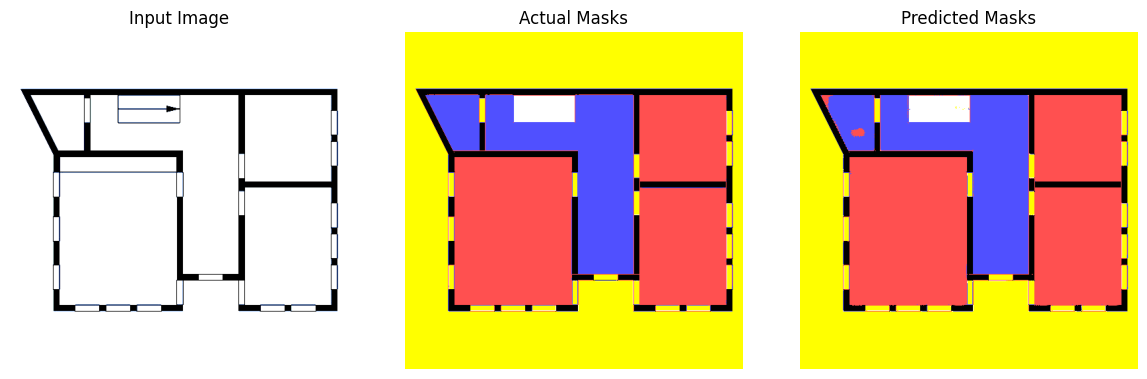

In [57]:
plot_segmentation(
    model=model, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='daft_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [58]:
# Model1 Saving
save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

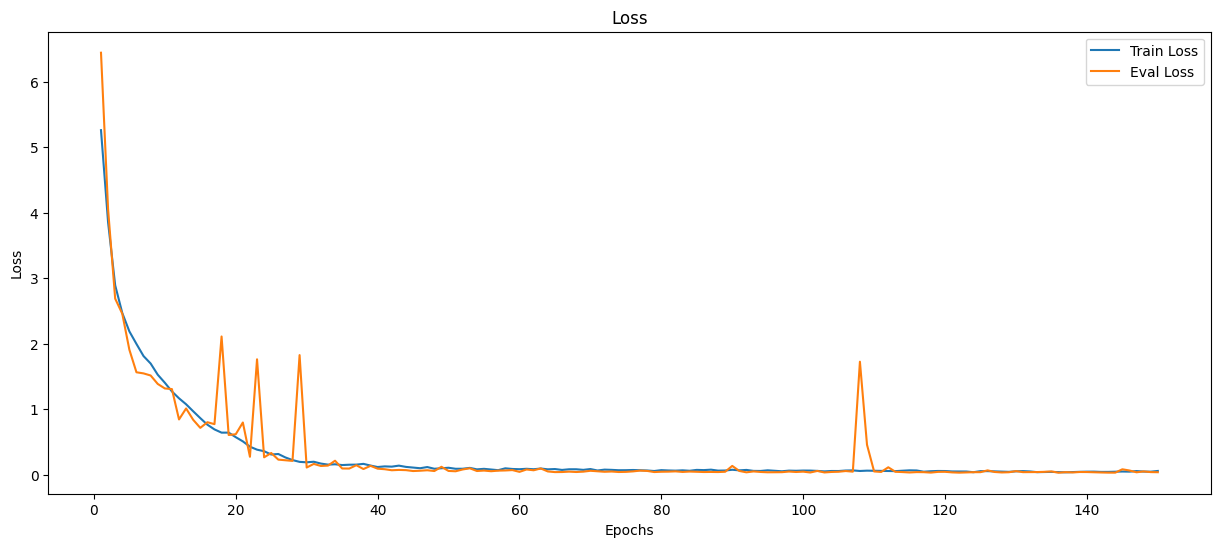

In [62]:
plt.figure(figsize = (15,6))
plt.title("Loss")
plt.plot(epoch_range, history['train_loss'], label="Train Loss")
plt.plot(epoch_range, history['eval_loss'], label="Eval Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')
plt.show()


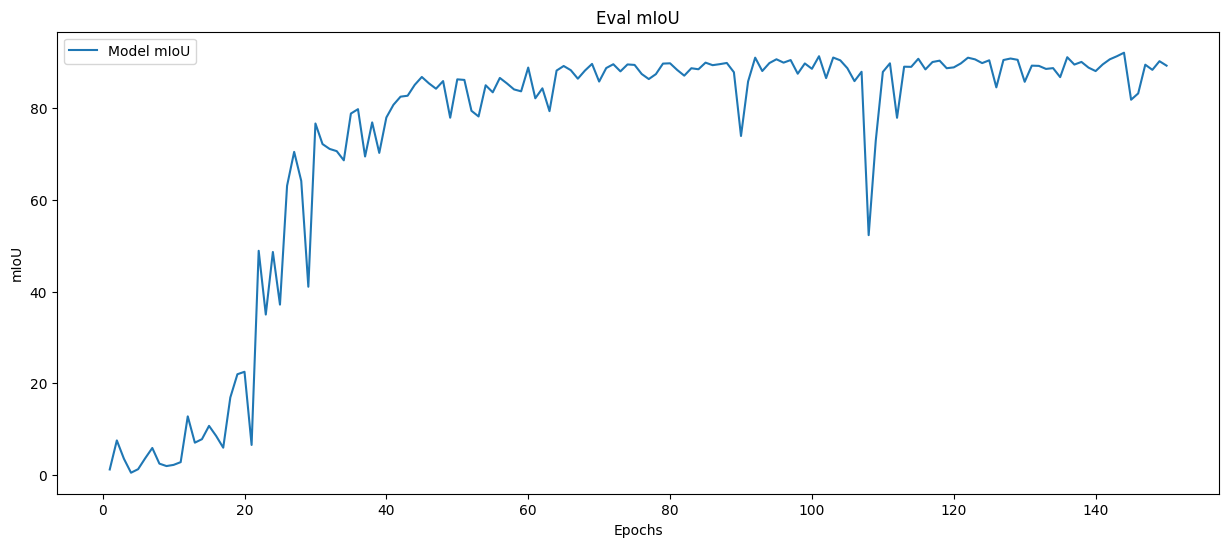

In [60]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['eval_miou'], label="Model mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

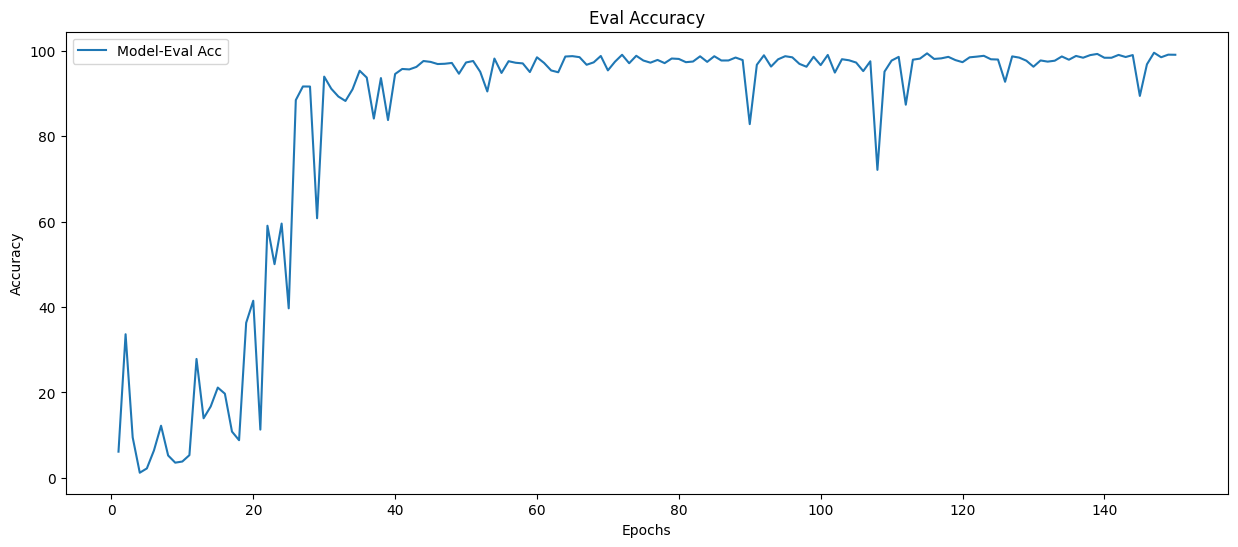

In [61]:
acc_tensor = torch.tensor(history['eval_acc'])
acc_tensor = acc_tensor.to('cpu')
acc_list = acc_tensor.tolist()

plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list, label="Model-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')